In [1]:
from utils import load_custom_dataset
import torch

/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
dataset = load_custom_dataset("smithsonian_butterflies_subset")

/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/datasets/load.py:2516: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


In [3]:
from torchvision import transforms

image_size = 64

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),
        # Map to (-1, 1)
    ]
)


In [4]:
batch_size = 16


def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

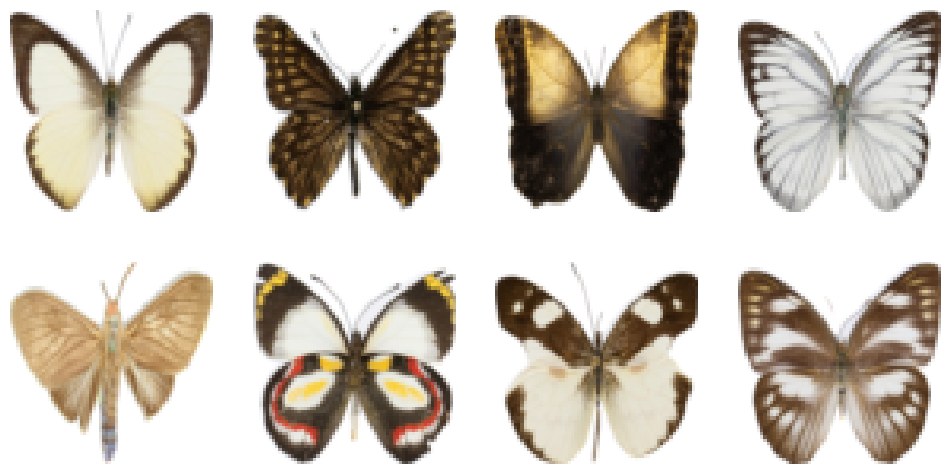

In [5]:
from utils import show_images

batch = next(iter(train_dataloader))
show_images(batch["images"][:8] * 0.5 + 0.5)

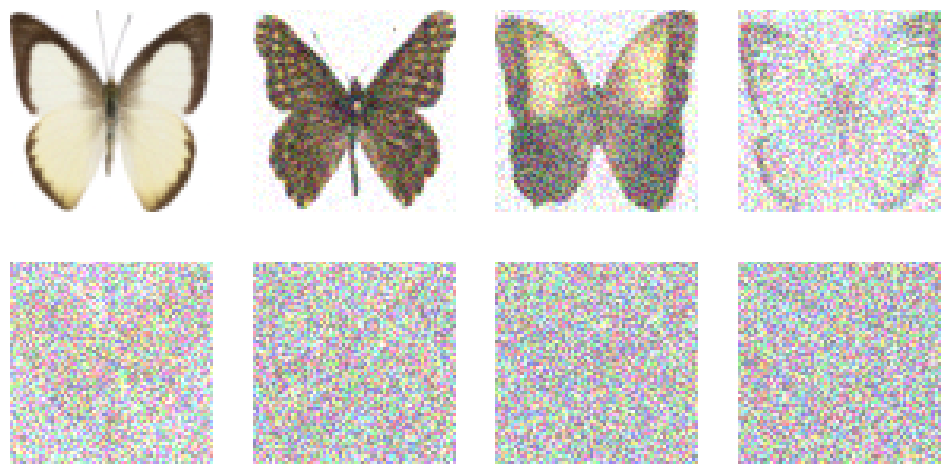

In [6]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)
timesteps = torch.linspace(0, 999, 8).long()
# We load 8 images from the dataset and
# add increasing amounts of noise to them
x = batch["images"][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [7]:
from diffusers import UNet2DModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet2DModel(
    in_channels=3,  # 3 channels for RGB images
    sample_size=64,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

with torch.no_grad():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample

out.shape


/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:264.)
  hidden_states = F.scaled_dot_product_attention(
/home/sajjad/PycharmProjects/my/.venv/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1244: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:320.)
  hidden_states = F.scaled_dot_product_attention(


torch.Size([8, 3, 64, 64])

In [11]:
def report_gpu():
    print(torch.cuda.is_available())


report_gpu()

True


In [8]:
from torch.nn import functional as F
import torch

num_epochs = 50  # How many runs through the data should we do?
lr = 1e-4  # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []  # Somewhere to store the loss values for later plotting
# Train the model (this takes a while!)
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (clean_images.shape[0],),
                                  device=device).long()

        # Add noise to the clean images according
        # to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        # The model also uses the timestep as an input
        # for additional conditioning
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Store the loss for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
from matplotlib import pyplot as plt

plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step")

OutOfMemoryError: HIP out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 1024.00 MiB of which 66.00 MiB is free. Of the allocated memory 736.65 MiB is allocated by PyTorch, and 25.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_HIP_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from diffusers import DDPMPipeline

pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images
show_images(ims, nrows=1)

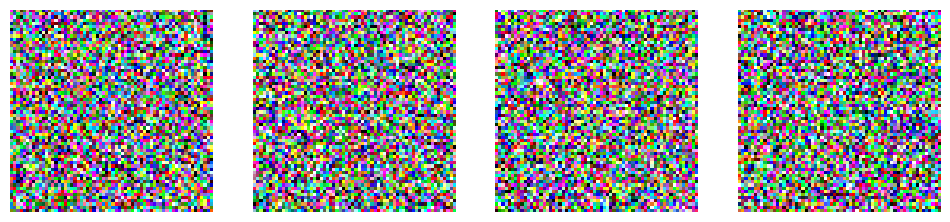

In [8]:
sample = torch.randn(4, 3, 64, 64).to(device)
for t in scheduler.timesteps:
    with torch.no_grad():
        noise_pred = model(sample, t)["sample"]
# Update sample with step
sample = scheduler.step(noise_pred, t, sample).prev_sample
show_images(sample.clip(-1, 1) * 0.5 + 0.5, nrows=1)

In [9]:
x = next(iter(train_dataloader))["images"][:8]
noise = torch.rand_like(x)

In [10]:
def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)
    # make sure it's broadcast-able

    return (x * (1 - amount) + noise * amount)  # equivalent to x.lerp(noise, amount)

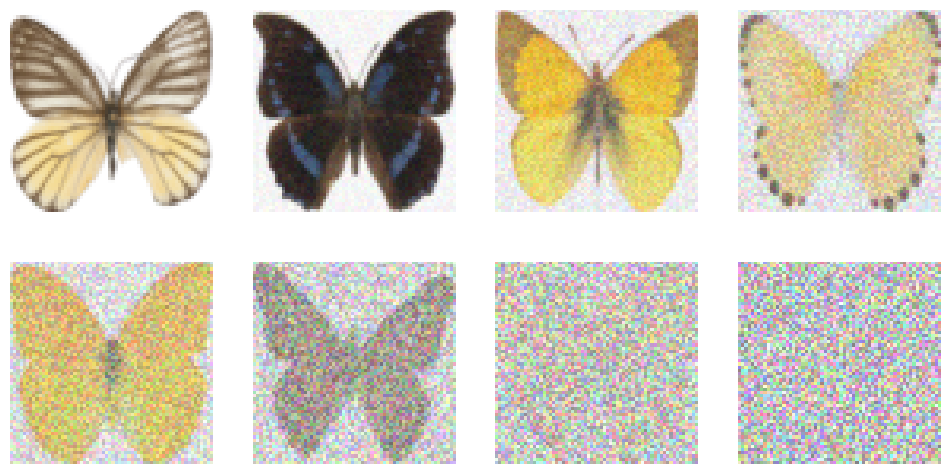

In [11]:
amount = torch.linspace(0, 1, 8)
noised_x = corrupt(x, noise, amount)
show_images(noised_x * 0.5 + 0.5)